In [4]:
import pandas as pd

PLOT_CONF = {'grid': False, 'figsize': (20,8), 'color': "#86bf91", 'zorder': 2}

In [5]:
df = pd.read_csv('do-10_products_20190924_185230.csv', sep=';')
df['modified_time'] = pd.to_datetime(df['modified_time'], unit='s')

# Data Overview

### Rows Number

In [6]:
len(df)

304970

### Columns

In [7]:
', '.join(df.columns.sort_values())

'available, categoryId, currencyId, id, image, modified_time, name, oldprice, price, title, type, url'

 ### Categories Description

General categories sorted by ascending price mean

In [8]:
df_categories = pd.DataFrame(
    {
        'cat_name': name,
        'cat_items': len(group),
        'price_min': group['price'].min(),
        'price_mean': group['price'].mean(),
        'price_median': group['price'].median(),
        'price_max': group['price'].max()
    }
    
    for name, group in df.groupby('categoryId')
    
).sort_values('price_mean').set_index('cat_name')

df_categories.at['Total', 'cat_items'] = df_categories['cat_items'].sum() # total sum of items

df_categories

,cat_items,price_min,price_mean,price_median,price_max
cat_name,,,,,
Игрушки и Хобби,13904.0,0.02,5.700033,4.960,1600.00
Спорт и развлечения,14300.0,0.01,6.166728,4.920,4161.29
Телефоны и Телекоммуникации,13974.0,0.15,6.354641,4.690,5000.00
Ювелирные изделия и часы,13892.0,0.01,6.417634,4.880,1033.13
Часы,14340.0,0.01,6.476165,4.740,4499.10
Компьютер & сеть,13738.0,0.00,6.747030,5.270,998.00
Бытовая электроника,14011.0,0.03,6.799874,5.000,1897.50
Обувь,10300.0,0.01,7.879891,5.605,875.00
Инструменты,13941.0,0.01,8.423931,5.160,4049.85


### Overall Price Distribution 

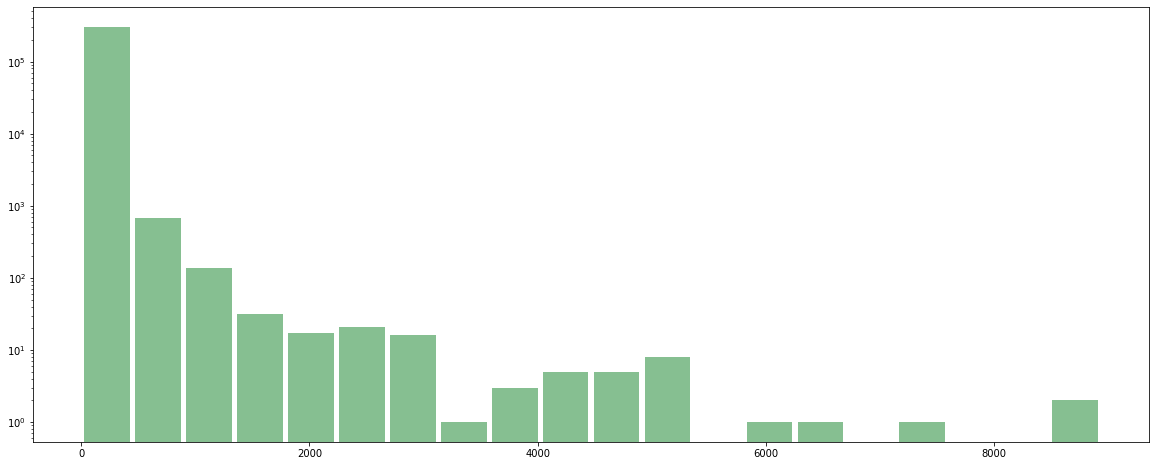

In [9]:
_ = df['price'].hist(**PLOT_CONF, log=True, bins=20, rwidth=0.9 )

### Overall Price Growth Rate  

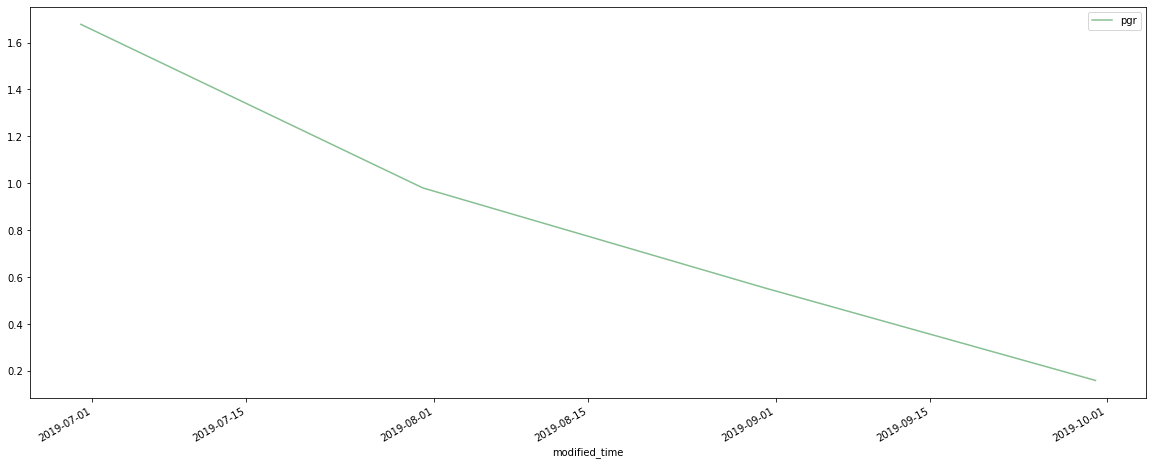

In [10]:
price_df = pd.DataFrame()
df_month_sample = df.set_index('modified_time').sort_index().resample('M').count()
price_df['pgr'] = (df_month_sample['price'] - df_month_sample['oldprice']) / df_month_sample['oldprice']
_ = price_df.dropna().plot(**PLOT_CONF)

### Categories Price Correlation

In [11]:
corr_df = pd.DataFrame()

for name, group in df.groupby('categoryId'):
    corr_df[name] = group.reset_index()['price']

c = corr_df.dropna().corr()

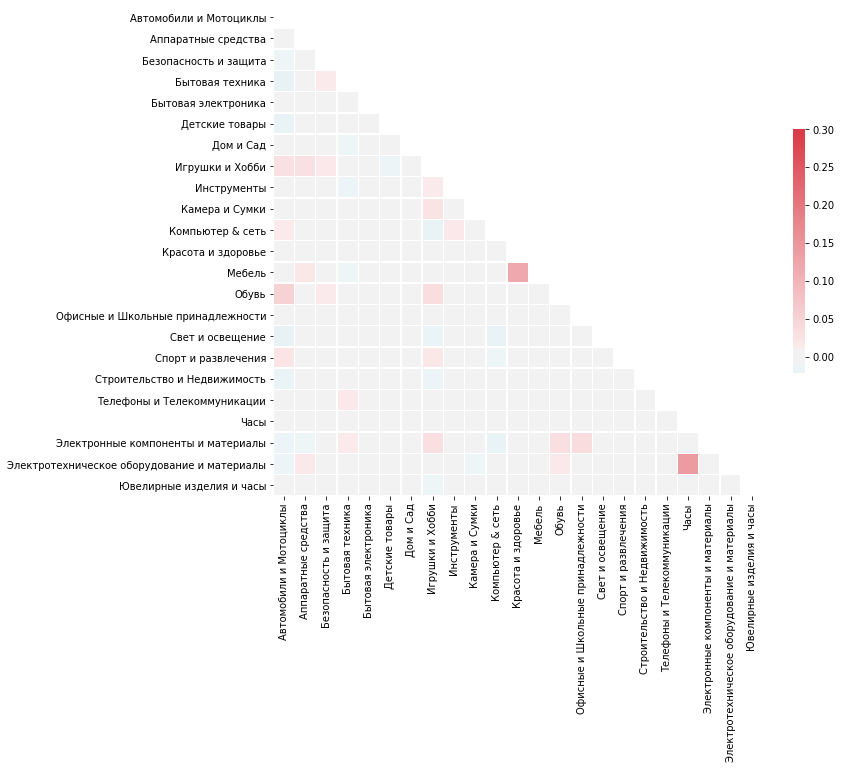

In [12]:
# Implemented in https://seaborn.pydata.org/examples/many_pairwise_correlations.html

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mask = np.triu(np.ones_like(c, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(c, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Overall Modification Time Distribution

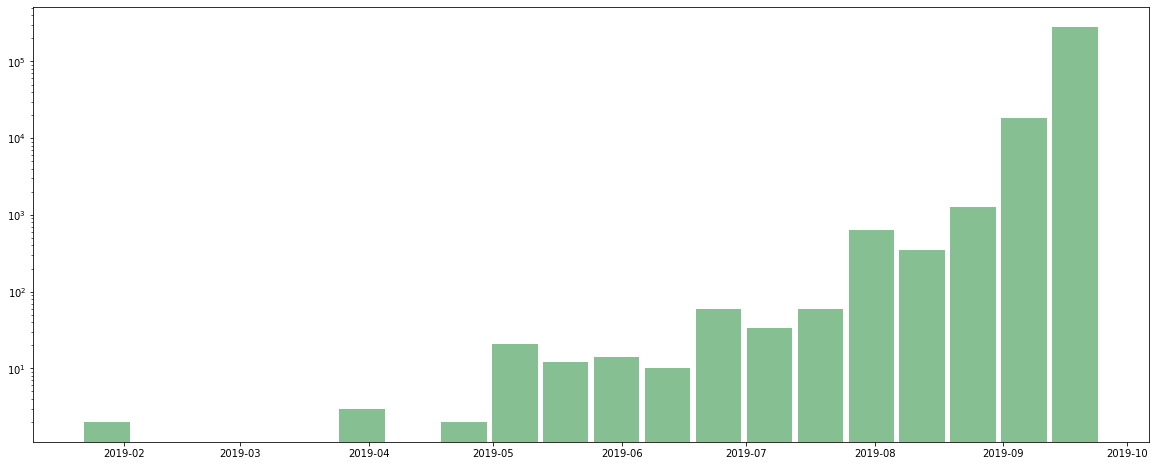

In [15]:
_ = df['modified_time'].hist(**PLOT_CONF, log=True, bins=20, rwidth=0.9)